In [33]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
from salishsea_tools import geo_tools, geo_tools, tidetools
import functools
from IPython.display import clear_output
import datetime


%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [2]:
# Function used to get chlorophyll data from text files produced in 2003, 2004, 2005 cruises
def extract_data(file_path):
    file_description = []
    default_cols = ["STATION", "DATE", "TIME", "LAT", "LON"]
    time_loc_data = 5*["NaN"]
    data_list = []
    with open(file_path) as f:
            indata = False
            for line in f:
                if not indata:
                    if line.startswith("%"):
                        file_description.append(line)
                    elif line.startswith("*"):
                        split_line = line.split()
                        columns = split_line[1:len(split_line)]
                        num_cols = len(columns)
                        indata = True
                else:
                    split_line = line.split()
                    if not line.startswith("S") and not line.startswith("T") and not line.startswith("F") and not line.startswith("P") and len(split_line) == num_cols:
                        data_list.append(time_loc_data + split_line)
                    elif len(split_line) > 0:
                        try:
                            station = split_line[0]
                        except:
                            station = "NaN"
                        try:
                            date = split_line[2] + " " + split_line[3] + " " + split_line[4]
                            date = pd.to_datetime(date, infer_datetime_format=True)
                        except:
                            date = pd.to_datetime("NaN", infer_datetime_format=True, errors = "coerce")
                        try:
                            time = split_line[5]
                        except:
                            time = "NaN"
                        try:
                            lat = split_line[6] + " " + split_line[7]
                            lon = split_line[9] + " " + split_line[10]
                        except:
                            lat, lon = "NaN", "NaN"
                        time_loc_data = [station,date,time,lat,lon]
            
    return(pd.DataFrame(data_list, columns = default_cols + columns))

In [3]:
# Iterate through top level chlorophyll data directory, grabbing data from applicable files

basedir = "/ocean/shared/SoG/btl/"
chl_dict = dict()

for subdir in os.listdir(basedir):
    if os.path.isdir(basedir + '/' + subdir):
        for file in os.listdir(basedir + '/' + subdir):
            if file.startswith("bottle") and file.endswith(".txt"):
                chl_dict[subdir] = extract_data(basedir + "/" + subdir + "/" + file)
                break

In [4]:
# Convert from sexagesimal lat or lon string to decimal lat or lon float
def strToLatLon(s):
    try:
        split_str = s.split()
        return(float(split_str[0]) + float(split_str[1])/60)
    except:
        return(np.nan)

In [5]:
# Convert chlorophyll dataframe column types

all_chl = pd.concat(chl_dict, join = "inner")
all_chl.reset_index(inplace = True)

all_chl["DEPTH"] = pd.to_numeric(all_chl["depth"], errors='coerce')
all_chl["chl002"] = pd.to_numeric(all_chl["chl002"], errors='coerce')
all_chl["chl020"] = pd.to_numeric(all_chl["chl020"], errors='coerce')
all_chl["chl200"] = pd.to_numeric(all_chl["chl200"], errors='coerce')

all_chl["DECIMAL_LAT"] = (all_chl["LAT"].apply(strToLatLon))
all_chl["DECIMAL_LON"] = (all_chl["LON"].apply(strToLatLon))
all_chl["DECIMAL_LON"] = -all_chl["DECIMAL_LON"] # needs to be negative to match grid lon/lats
all_chl["STATION_LAT"] =  all_chl.groupby("STATION")["DECIMAL_LAT"].transform(np.median)
all_chl["STATION_LON"] =  all_chl.groupby("STATION")["DECIMAL_LON"].transform(np.median)

In [6]:
# Create smaller data frame with location of stations
station_lon_lat = all_chl[["STATION", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

In [7]:
# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [8]:
# Grab nitrate data
nitrate_df = pd.read_excel('/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPedit.xls')
nitrate_df = nitrate_df[~pd.isnull(nitrate_df["Date"]) & (nitrate_df["Date"] != "6/?/2015")]
nitrate_df["Date"] = pd.to_datetime(nitrate_df["Date"])
nitrate_df = nitrate_df.sort_values("Date")

(array([ 735744.,  735746.,  735748.,  735750.,  735752.,  735754.,
         735756.,  735758.]), <a list of 8 Text xticklabel objects>)

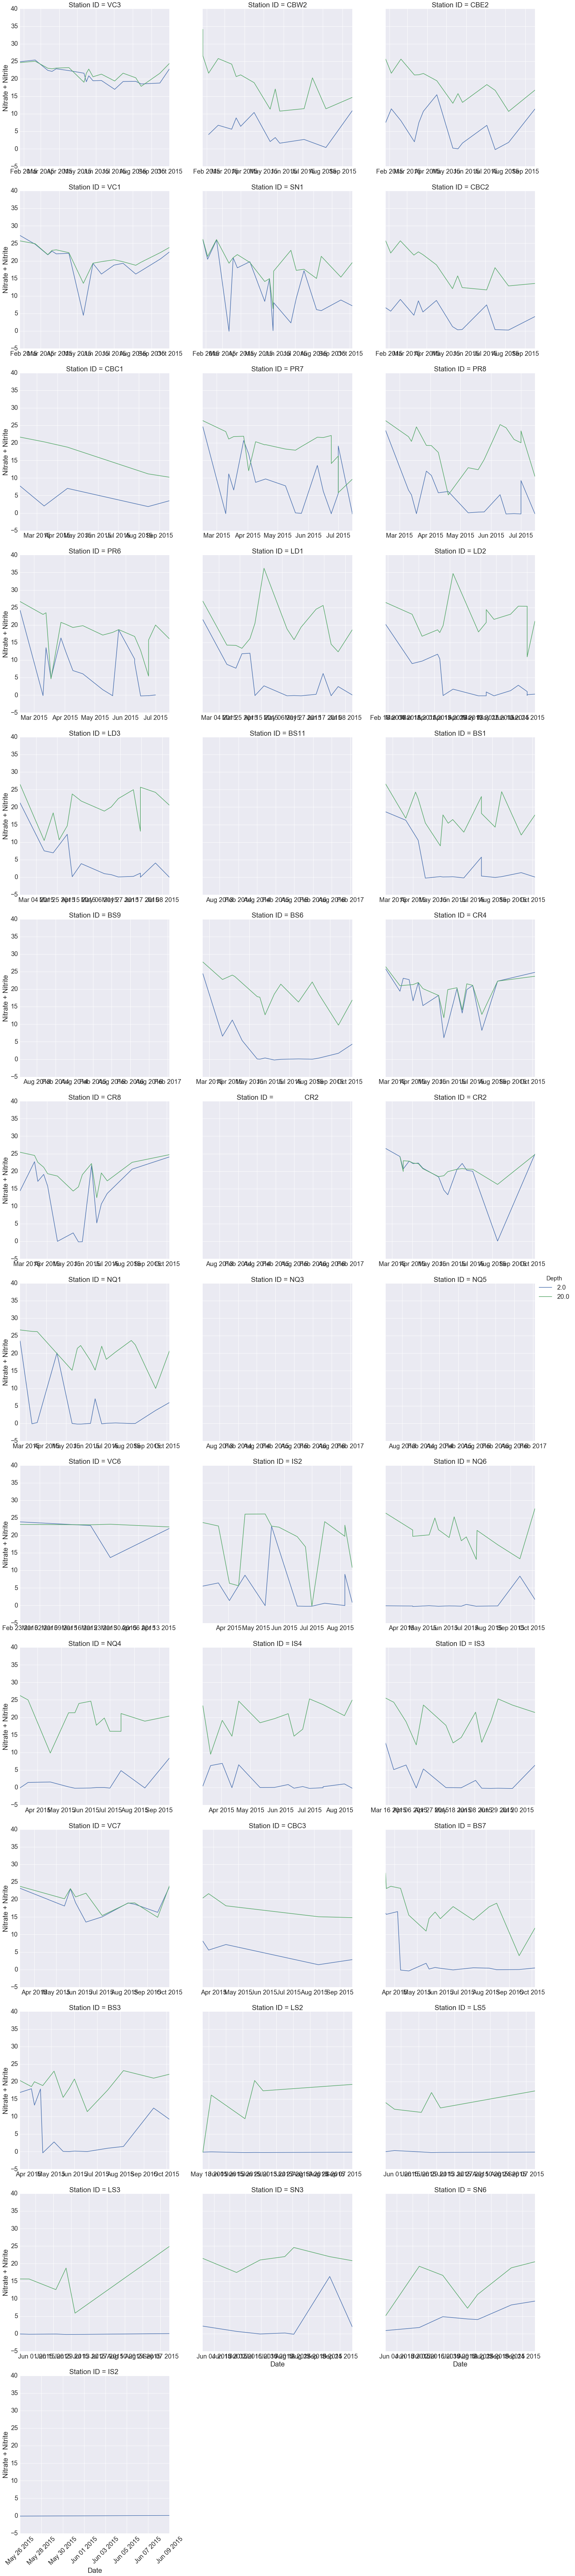

In [9]:
# Plot nitrate data
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nitrate_df, col = "Station ID", col_wrap=3, hue = "Depth", size =8, sharex = False)
fg.map(plt.plot,"Date", "Nitrate + Nitrite").add_legend()
plt.xticks(rotation=45)

In [10]:
# Grab plankton data from excel file
plank_df_list = []
for i in range(1,4):
    df = pd.read_excel('/ocean/shared/SoG/PHYTO/Profiles_by_station.xls',i)
    top_index = pd.Index(df["Vol"]).get_loc("Species")
    bottom_index = pd.Index(df["Vol"]).get_loc("Carbon (ng/l)")
    df = pd.concat([df.iloc[:top_index], df.iloc[(bottom_index + 1):]])
    df = df.transpose()
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df.reset_index(inplace = True)
    plank_df_list.append(df)

In [82]:
# convert plankton dataframe data types

all_plank = pd.concat(plank_df_list,  axis=0, ignore_index=True)

all_plank.loc[all_plank["Date"] == "14/15-Apr-04", "Date"] = "2004-04-14 00:00:00"

all_plank["STATION"] = "S" + all_plank["Site"].astype(str).str.strip()
all_plank["DATE"] = pd.to_datetime(all_plank["Date"], format='%Y-%m-%d', errors = "coerce")
all_plank["DATE_STR"] = [d.strftime('%Y-%m-%d') if not pd.isnull(d) else np.nan for d in all_plank['DATE']] 
all_plank["MONTH"] = all_plank["DATE"].apply(lambda x: x.month)
all_plank["DAY_OF_MONTH"] = all_plank["DATE"].apply(lambda x: x.day)
all_plank["DEPTH"] = pd.to_numeric(all_plank["Depth (m)"], errors = "coerce")
all_plank["DIATOMS(ngC/L)"] = pd.to_numeric(all_plank["Total diatoms"], errors = "coerce")
all_plank["DIATOMS(mmolN/m3)"] = all_plank["DIATOMS(ngC/L)"]*(10**-9)*(0.083259)*(16.0/106)*(10**3)*(10**3)

In [67]:
# Choose which values to add to nowcast dataframe

tracers = ["PHY2"]

plot_months = ["mar"]

plot_hours = np.array([0, 12, 18])

max_depth = 20
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

model_points = station_lon_lat["MODEL_POINT"]
model_js = [x[0] for x in model_points] 
model_is = [x[1] for x in model_points] 

stations = station_lon_lat["STATION"]

In [68]:
# Iterate through nowcast green results, grabbing certain tracers, locations, and dates/times
# Create pandas dataframe and save result

load_new_dataset = True

if load_new_dataset:
    nowcast_dir = "/results/SalishSea/nowcast-green/" #"/data/jpetrie/MEOPAR/SalishSea/results/nowcast_results/"

    month_num = {"jan": "01","feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12" }

    dataframe_list = []
    num_files = 0
    start_time = datetime.datetime.now()
    for subdir in os.listdir(nowcast_dir):
        if os.path.isdir(nowcast_dir + '/' + subdir) and re.match("[0-9]{2}[a-z]{3}[0-9]{2}", subdir):
            month_str = subdir[2:5]
            date_str = "20" + subdir[5:7] + month_num[month_str] + subdir[0:2]
            tracer_file = "SalishSea_1h_" + date_str + "_" + date_str + "_ptrc_T.nc"
            tracer_path = nowcast_dir + "/" + subdir + "/" + tracer_file
            if os.path.isfile(tracer_path) and month_str in plot_months:
                grid_t = xr.open_dataset(tracer_path)
                result_hours = pd.DatetimeIndex(grid_t.time_centered.values).hour
                time_indices = np.where([(x in plot_hours) for x in result_hours])
                
                J, T, Z = np.meshgrid(model_js,time_indices,depth_indices, indexing = 'ij')
                I, T, Z = np.meshgrid(model_is,time_indices,depth_indices, indexing = 'ij')
                
                tracer_dataframes = []
                for t in tracers:
                    station_slice = grid_t[t].values[T,Z,J,I]
                    slice_xarray = xr.DataArray(station_slice,
                                     [stations,result_hours[time_indices], result_depths[depth_indices]],
                                     ["STATION", "HOUR", "DEPTH"], 
                                     t)
                    slice_dataframe = slice_xarray.to_dataframe()
                    slice_dataframe.reset_index(inplace = True)
                    tracer_dataframes.append(slice_dataframe)
                merged_tracers = functools.reduce(lambda left,right: pd.merge(left,right,on=["STATION", "HOUR", "DEPTH"]), tracer_dataframes)
                merged_tracers["DATE"] = date_str
                merged_tracers["MONTH"] = int(month_num[month_str])
                dataframe_list.append(merged_tracers)

                num_files = num_files + 1
                run_time = datetime.datetime.now() - start_time
                clear_output()
                print("Files loaded:" + str(num_files))
                print("Date of most recent nowcast load: " + date_str)
                print("Time loading: ")
                print(run_time)
                print("\n\n\n")
                print(merged_tracers)

    nowcast_df = pd.concat(dataframe_list)    
    t = datetime.datetime.now()
    time_string = str(t.year) +"_"+ str(t.month) +"_"+ str(t.day) +"_"+ str(t.hour) +"_"+ str(t.minute)
    nowcast_df.to_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/"+ time_string + ".pkl") 
    
else: 
    past_dataset_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/2016_7_28_14_34.pkl"
    nowcast_df = pd.read_pickle(past_dataset_path)

Files loaded:31
Date of most recent nowcast load: 20160323
Time loading: 
0:02:11.588489




     STATION  HOUR      DEPTH       PHY2      DATE  MONTH
0       S2-3     0   0.500000   6.861913  20160323      3
1       S2-3     0   1.500003  10.738915  20160323      3
2       S2-3     0   2.500011  10.782527  20160323      3
3       S2-3     0   3.500031  10.818778  20160323      3
4       S2-3     0   4.500071  10.837396  20160323      3
5       S2-3     0   5.500151  10.855765  20160323      3
6       S2-3     0   6.500310  11.002789  20160323      3
7       S2-3     0   7.500623  12.273889  20160323      3
8       S2-3     0   8.501236  12.900131  20160323      3
9       S2-3     0   9.502433  11.574366  20160323      3
10      S2-3     0  10.504766   9.316854  20160323      3
11      S2-3     0  11.509312   7.068533  20160323      3
12      S2-3     0  12.518167   5.454793  20160323      3
13      S2-3     0  13.535412   4.509493  20160323      3
14      S2-3     0  14.568982   3.946

In [80]:
grid_t.PHY2


<xarray.DataArray 'PHY2' (time_counter: 24, deptht: 40, y: 898, x: 398)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0., ...,  0.,

In [69]:
nowcast_df["DAY_OF_MONTH"] = pd.to_numeric(nowcast_df["DATE"])%100
nowcast_df["MONTH"] = ((pd.to_numeric(nowcast_df["DATE"])%10000))//100

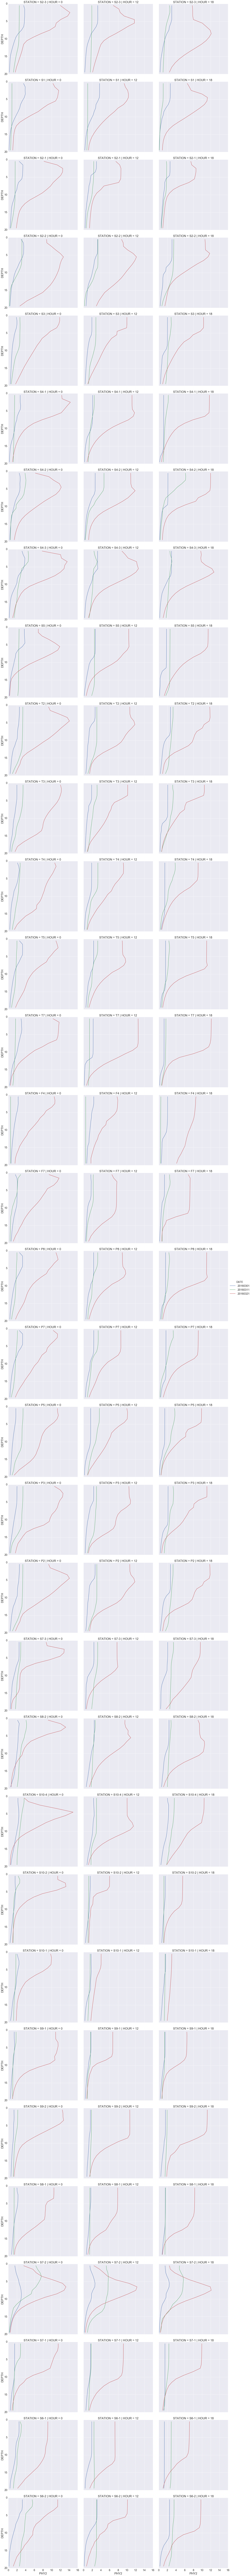

In [70]:
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nowcast_df[(pd.to_numeric(nowcast_df["DAY_OF_MONTH"])).isin([1,11,21])], hue = "DATE",col = "HOUR", row = "STATION", size =8)
fg.map(plt.plot, "PHY2", "DEPTH").add_legend()
plt.gca().invert_yaxis()

/home/jpetrie/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=54284.634, right=54284.634
  'left=%s, right=%s') % (left, right))


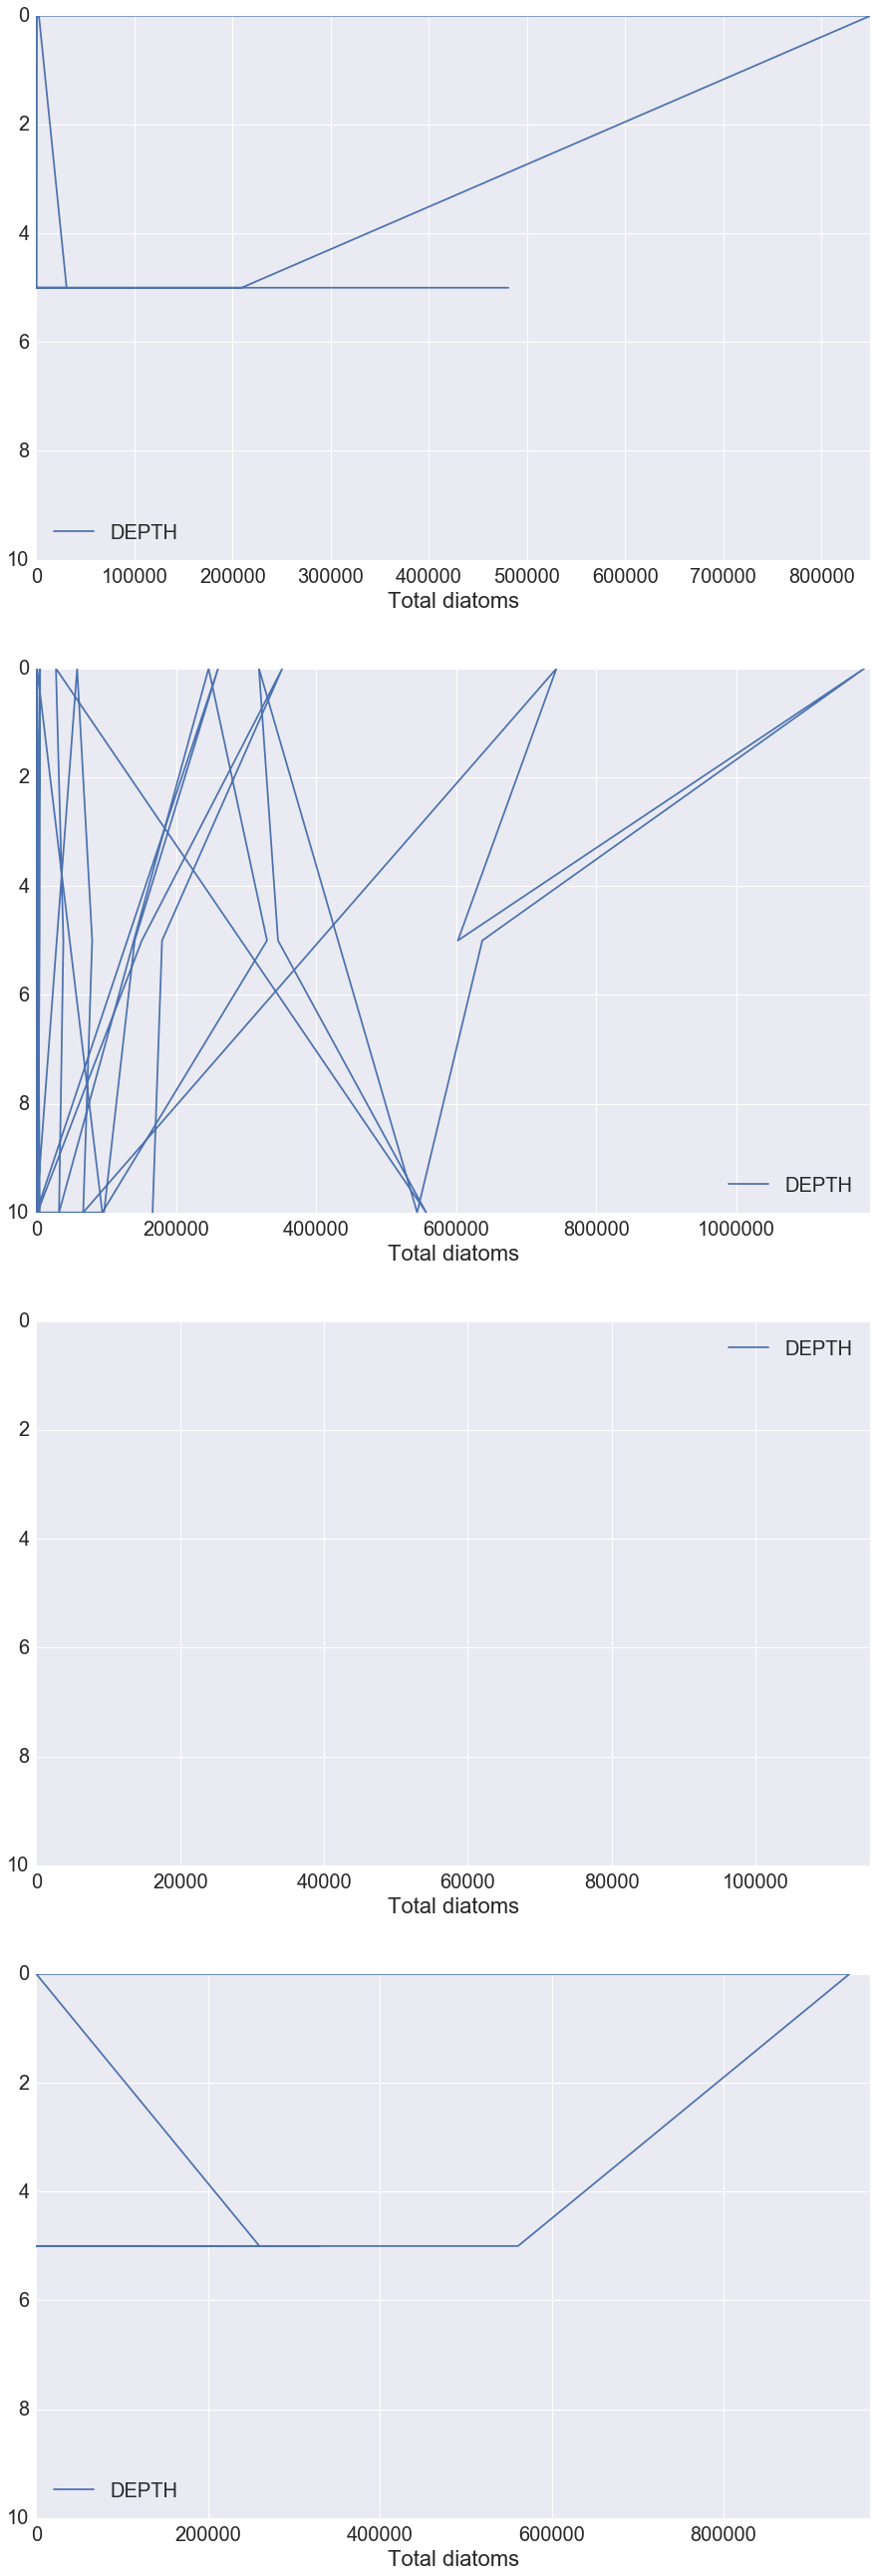

In [17]:
cmap = plt.get_cmap('Set2')

months = np.unique(all_plank.MONTH)
stations = np.unique(all_plank.STATION)

fig, ax = plt.subplots(len(stations),1, figsize= (15,45))#len(months))

for i, station in enumerate(stations):
    #for j, month in enumerate(months):
    x = all_plank[(all_plank["STATION"] == station) 
                    & all_plank["Total diatoms"].notnull()
                    & all_plank["DATE_STR"].notnull()]
    #print("Station: " + station)
    #print(x)
    #print("\n\n\n\n\n\n\n\n")
    if(len(x) > 0):
        categories = np.unique(x["DATE_STR"])
        colors = cmap(np.linspace(0, 1, len(categories)))
        colordict = dict(zip(categories, colors))  

        #grouped = x.groupby('DATE_STR')
        #for key, group in grouped:
        x.plot(ax = ax[i], y="DEPTH", x='Total diatoms')
        #for key in categories:
        #    x[x["DATE_STR"] == key].plot(ax = ax[i], x="DEPTH", y='Total Ps',label=key, color=colordict[key])
        ax[i].set_ylim(10,0)
        ax[i].set_xlim(0,max(x["Total Ps"]) )

#plt.tight_layout()

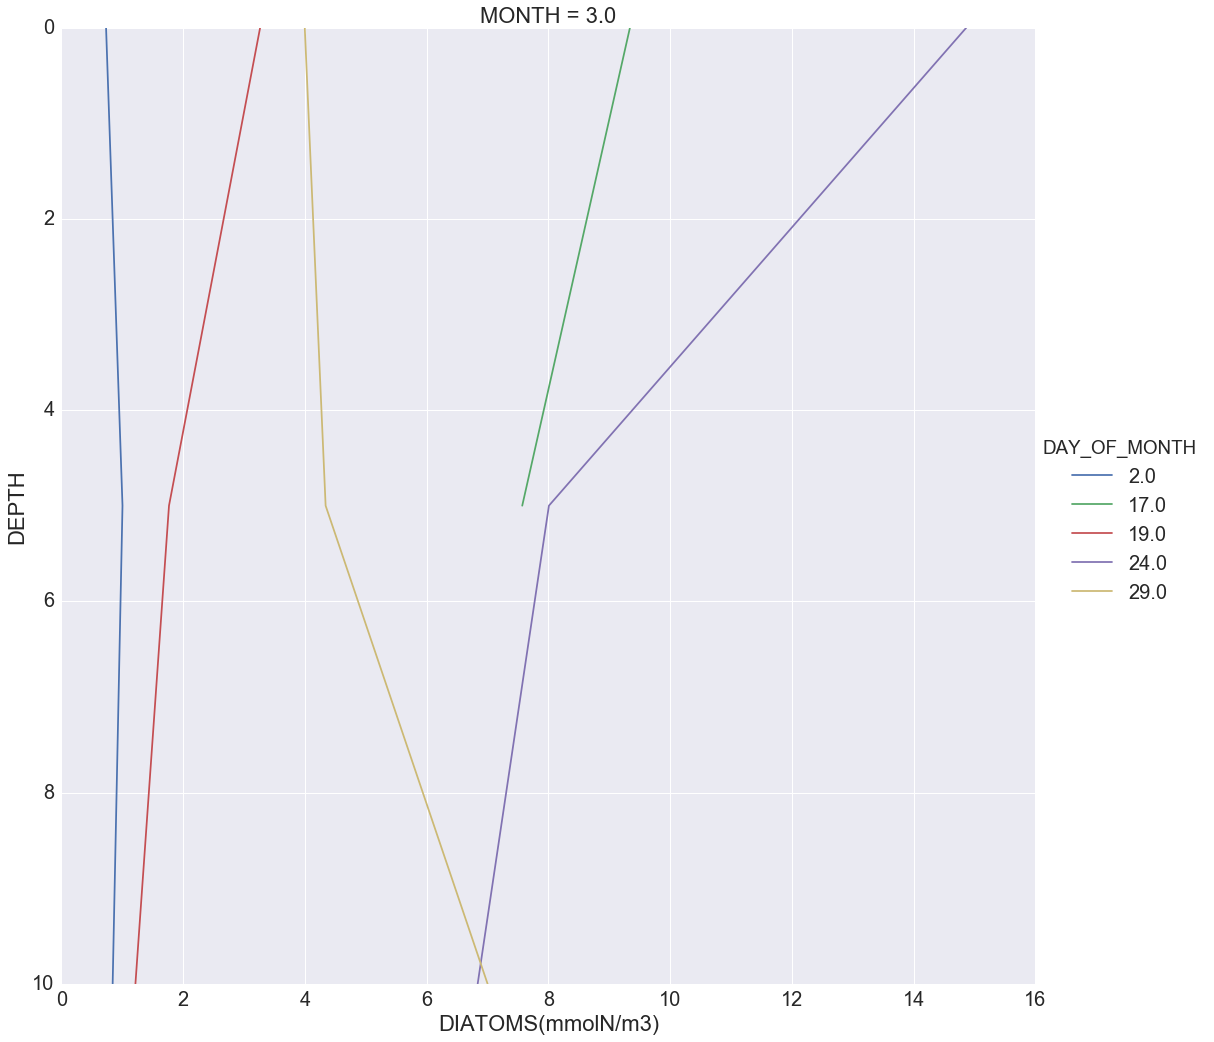

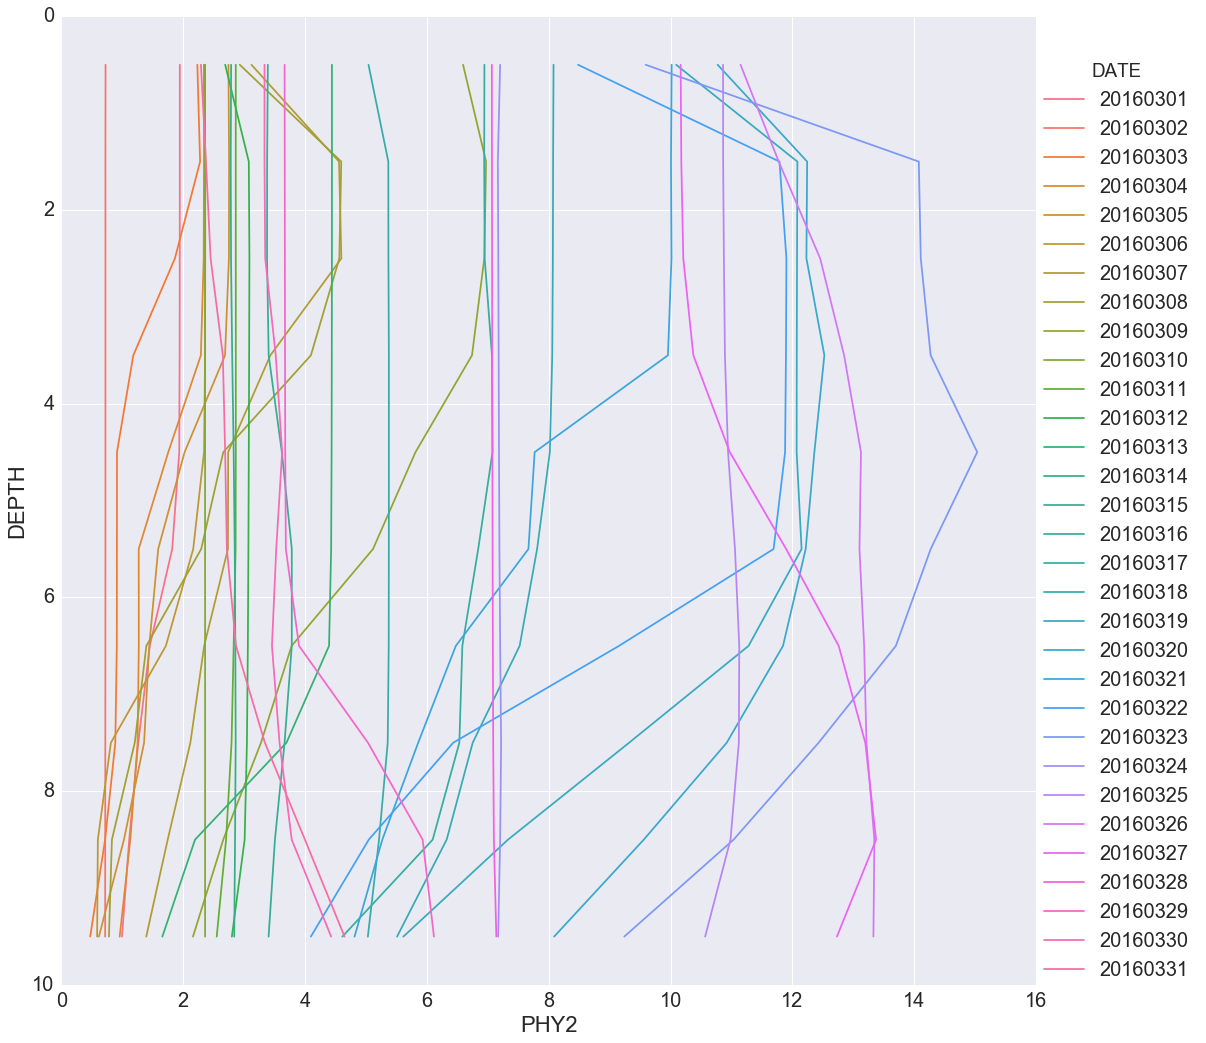

In [83]:
# S3 is the only station with multiple depth measurements on the same day for total diatoms
# March and April are the only months with significant diatom population measured at S3


sns.set(font_scale = 2)
fg = sns.FacetGrid(data = all_plank.query("STATION == 'S3' & MONTH == 3"), col = "MONTH", hue = "DAY_OF_MONTH", size =15)
fg.map(plt.plot,"DIATOMS(mmolN/m3)", "DEPTH").add_legend()
#fg.xticks(rotation=45)
plt.gca().invert_yaxis()

sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nowcast_df.query("STATION == 'S3' & HOUR == 12 & MONTH == 3 & DEPTH <= 10"), hue = "DATE", size =15)
fg.map(plt.plot, "PHY2", "DEPTH").add_legend()
plt.gca().invert_yaxis()

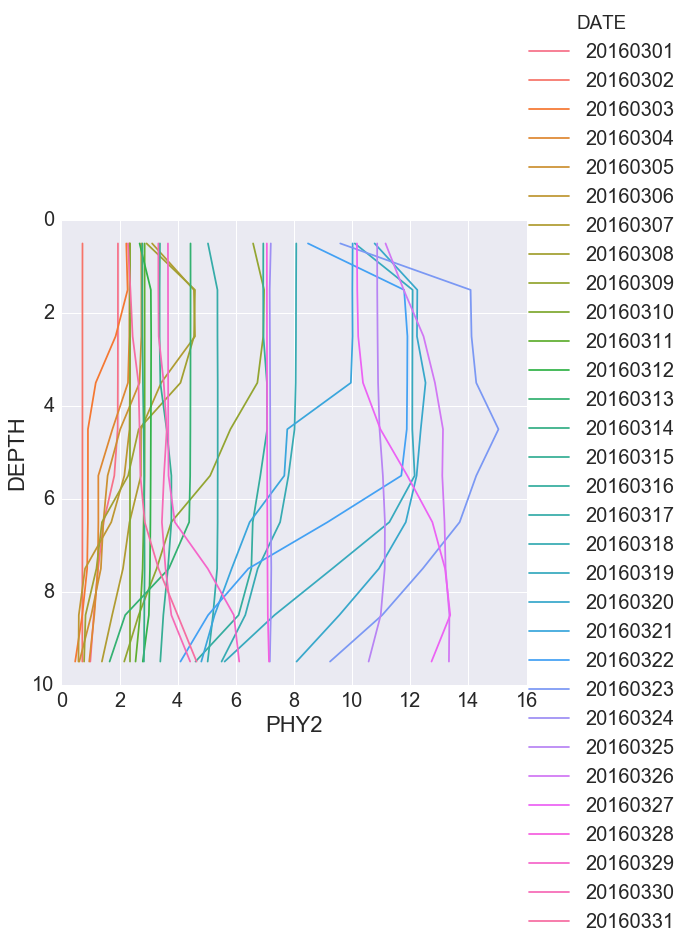

In [76]:
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nowcast_df.query("STATION == 'S3' & HOUR == 12 & MONTH == 3 & DEPTH <= 10"), hue = "DATE", size =8)
fg.map(plt.plot, "PHY2", "DEPTH").add_legend()
plt.gca().invert_yaxis()